## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.models.cifar10.wideresnet import wrn_22_cat, wrn_22, WideResNetConcat
torch.backends.cudnn.benchmark = True
PATH = Path("data/cifar10/")
os.makedirs(PATH,exist_ok=True)

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

bs=512
sz=32
workers=7

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

def pad(img, p=4, padding_mode='reflect'):
    return Image.fromarray(np.pad(np.asarray(img), ((p, p), (p, p), (0, 0)), padding_mode))

def torch_loader(data_path, size):
    if not os.path.exists(data_path+'/train'): download_cifar10(data_path)

    # Data loading code
    traindir = os.path.join(data_path, 'train')
    valdir = os.path.join(data_path, 'test')
    normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
    tfms = [transforms.ToTensor(), normalize]

    train_tfms = transforms.Compose([
        pad, # TODO: use `padding` rather than assuming 4
        transforms.RandomCrop(size),
        transforms.RandomHorizontalFlip(),
    ] + tfms)
    val_tfms = transforms.Compose(tfms)

    train_dataset = datasets.ImageFolder(traindir, train_tfms)
    val_dataset = datasets.ImageFolder(valdir, val_tfms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs*2, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    data.sz = size
    return data

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [5]:
data = torch_loader(str(PATH), sz)

In [15]:
'''Pre-activation ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Identity Mappings in Deep Residual Networks. arXiv:1603.05027
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)
    

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, concatpool=False):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.pool = AdaptiveConcatPool2d() if concatpool else nn.AdaptiveMaxPool2d((1,1))
        
        self.linear = nn.Linear(512*block.expansion*(concatpool+1), num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
#         out = F.adaptive_max_pool2d(out, 1)
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out))

def preact_resnet18(): return PreActResNet(PreActBlock, [2,2,2,2])
def preact_resnet2332(): return PreActResNet(PreActBlock, [2,3,3,2])
def preact_resnet3333(): return PreActResNet(PreActBlock, [3,3,3,3])
def preact_resnet34(): return PreActResNet(PreActBlock, [3,4,6,3])
def preact_resnet50(): return PreActResNet(PreActBottleneck, [3,4,6,3])
def preActResNet101(): return PreActResNet(PreActBottleneck, [3,4,23,3])
def preActResNet152(): return PreActResNet(PreActBottleneck, [3,8,36,3])


In [13]:
# m = WideResNetConcat(num_groups=3, N=3, num_classes=10, k=1, drop_p=0.)

### Without pool

In [11]:
m = preact_resnet18()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
%time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(12,22,0.95,0.85), loss_scale=512)
# phases = [
#     TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
#     TrainingPhase(**def_phase, epochs=6, lr=(.05,.9), lr_decay=DecayType.COSINE, momentum=(0.95,0.85), momentum_decay=DecayType.COSINE),
#     TrainingPhase(**def_phase, epochs=4, lr=1, momentum=0.85),
#     TrainingPhase(**def_phase, epochs=7, lr=(.9,.01), lr_decay=DecayType.COSINE, momentum=(0.85,0.95), momentum_decay=DecayType.COSINE),
#     TrainingPhase(**def_phase, epochs=3, lr=(.01,.0005), lr_decay=DecayType.LINEAR, momentum=(0.95))]

# learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.548514   1.458414   0.5059    
    1      1.197921   1.095902   0.6147                   
    2      0.973413   1.059713   0.638                     
    3      0.814994   0.797659   0.722                     
    4      0.679065   0.919106   0.7008                    
    5      0.595604   0.731411   0.7461                    
    6      0.528443   0.61003    0.79                      
    7      0.475986   0.525616   0.8199                    
    8      0.432675   0.662902   0.7817                    
    9      0.404445   0.477596   0.8416                    
    10     0.365769   0.565556   0.822                     
    11     0.34004    0.496644   0.8357                    
    12     0.299456   0.45601    0.8493                    
    13     0.283647   0.403581   0.8611                    
    14     0.239966   0.355904   0.8836                    
    15     0.213908   0.346475   0.8852                   

[array([0.26741]), 0.9224000018119812]

### With pool

In [16]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
%time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(12,22,0.95,0.85), loss_scale=512)
# phases = [
#     TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
#     TrainingPhase(**def_phase, epochs=6, lr=(.05,.9), lr_decay=DecayType.COSINE, momentum=(0.95,0.85), momentum_decay=DecayType.COSINE),
#     TrainingPhase(**def_phase, epochs=4, lr=1, momentum=0.85),
#     TrainingPhase(**def_phase, epochs=7, lr=(.9,.01), lr_decay=DecayType.COSINE, momentum=(0.85,0.95), momentum_decay=DecayType.COSINE),
#     TrainingPhase(**def_phase, epochs=3, lr=(.01,.0005), lr_decay=DecayType.LINEAR, momentum=(0.95))]

# learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.575032   1.724038   0.4309    
    1      1.187866   1.314066   0.572                    
    2      0.956739   1.07919    0.6446                    
    3      0.771508   0.812311   0.7199                    
    4      0.651959   0.917808   0.7014                    
    5      0.565921   0.725721   0.7607                    
    6      0.529047   0.651835   0.7864                    
    7      0.482334   0.7427     0.7582                    
    8      0.443646   0.556046   0.8103                    
    9      0.412336   0.515939   0.8264                    
    10     0.376727   0.572458   0.8153                    
    11     0.341356   0.597042   0.815                     
    12     0.314225   0.520334   0.839                     
    13     0.281799   0.383897   0.8744                    
    14     0.245815   0.383549   0.8775                    
    15     0.217316   0.419567   0.8651                   

[array([0.28541]), 0.9171999992370605]

In [18]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=5e-5
lr=1.2
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
%time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
# phases = [
#     TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
#     TrainingPhase(**def_phase, epochs=6, lr=(.05,.9), lr_decay=DecayType.COSINE, momentum=(0.95,0.85), momentum_decay=DecayType.COSINE),
#     TrainingPhase(**def_phase, epochs=4, lr=1, momentum=0.85),
#     TrainingPhase(**def_phase, epochs=7, lr=(.9,.01), lr_decay=DecayType.COSINE, momentum=(0.85,0.95), momentum_decay=DecayType.COSINE),
#     TrainingPhase(**def_phase, epochs=3, lr=(.01,.0005), lr_decay=DecayType.LINEAR, momentum=(0.95))]

# learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

 32%|███▏      | 31/98 [00:02<00:06, 11.11it/s, loss=1.98]

Exception in thread Thread-146:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.680362   3.253288   0.3729    
    1      1.482544   1.609691   0.4481                   
    2      1.163796   1.195272   0.6053                   
    3      0.987197   1.034303   0.6383                    
    4      0.840345   0.922554   0.6994                    
    5      nan        nan        0.1                       
    6      nan        nan        0.1                     
 30%|██▉       | 29/98 [00:02<00:06, 11.07it/s, loss=nan]

Process Process-777:
Process Process-771:
Process Process-775:
Process Process-776:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in 

  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7fe6900f1f10>
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm_notebook.py", line 187, in __iter__
    yield obj
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 175, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 15900) exited unexpectedly with exit code 1.


KeyboardInterrupt: 

In [19]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=5e-5
lr=1.2
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=6, lr=(.05,.9), lr_decay=DecayType.COSINE, momentum=(0.95,0.85), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=4, lr=1, momentum=0.85),
    TrainingPhase(**def_phase, epochs=7, lr=(.9,.01), lr_decay=DecayType.COSINE, momentum=(0.85,0.95), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=3, lr=(.01,.0005), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.58888    2.268781   0.358     
    1      1.330952   2.700681   0.3216                   
    2      1.0324     1.909272   0.5134                   
    3      0.806186   1.007916   0.6665                    
    4      0.695327   1.068196   0.679                     
    5      0.615858   0.575531   0.8014                    
    6      0.573678   0.83847    0.7455                    
    7      0.547463   0.812909   0.7374                    
    8      0.504218   0.614202   0.8032                    
    9      0.476235   0.54882    0.8191                    
    10     0.445325   1.151848   0.719                     
    11     0.393621   0.47237    0.8542                    
    12     0.376854   0.506546   0.8463                    
    13     0.330198   0.426037   0.8653                    
    14     0.291321   0.420512   0.8608                    
    15     0.240045   0.37889    0.8779                    

[array([0.27203]), 0.9175000017166137]

In [29]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=5e-5
lr=1.2
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.01,.02), lr_decay=DecayType.EXPONENTIAL, momentum=0.95)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.513263   1.572274   0.4598    



[array([1.57227]), 0.45979999990463255]

In [30]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=5e-5
lr=1.2
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.01,.02), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=8, lr=(.02,1), lr_decay=DecayType.COSINE, momentum=(0.95,0.85), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=4, lr=1, momentum=0.85),
    TrainingPhase(**def_phase, epochs=8, lr=(1,.01), lr_decay=DecayType.COSINE, momentum=(0.85,0.95), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=5, lr=(.01,.0005), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.519843   1.447052   0.4779    
    1      1.162748   2.281788   0.4349                   
    2      1.141875   1.403912   0.6048                   
    3      0.852955   0.893409   0.7146                    
    4      0.685746   0.914835   0.7071                    
    5      0.61813    0.651454   0.7834                    
    6      0.616182   0.731231   0.7676                    
    7      0.562869   1.166888   0.6899                    
    8      0.484735   0.5032     0.83                      
    9      0.46338    0.704105   0.785                     
    10     0.441603   0.507102   0.8327                    
    11     0.42213    0.65801    0.7793                    
    12     0.389854   0.438473   0.8564                    
    13     0.364727   0.63655    0.8154                    
    14     0.3442     0.546502   0.8253                    
    15     0.321018   0.445805   0.8609                    

[array([0.25682]), 0.9225000015258789]

In [36]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=5e-5
lr=1.2
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.04), lr_decay=DecayType.LINEAR, momentum=0.95)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.434231   1.189548   0.5689    



[array([1.18955]), 0.5688999989509582]

In [39]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=5e-5
lr=1.2
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.04), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=8, lr=(.02,1), lr_decay=DecayType.COSINE, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.445796   1.215815   0.5574    
    1      1.1894     2.79712    0.4001                   
    2      1.219395   1.813344   0.5312                   
    3      0.873536   1.315986   0.6321                    
    4      0.742008   0.931552   0.6865                    
    5      0.647099   0.668615   0.7715                    
    6      0.612087   1.124609   0.6898                    
    7      0.559995   0.653557   0.777                     
    8      0.527178   0.576201   0.8114                    



[array([0.5762]), 0.8114000003814698]

In [40]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=5e-5
lr=1.2
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.04), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=8, lr=(.04,1), lr_decay=DecayType.EXPONENTIAL, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.421114   1.177442   0.575     
    1      1.235079   1.302384   0.568                    
    2      1.020289   1.431194   0.5482                   
    3      0.799422   1.088784   0.6679                    
    4      0.681878   1.054612   0.6722                    
    5      0.601654   0.626858   0.7836                    
    6      0.555011   0.734665   0.7649                    
    7      0.565445   0.818552   0.7348                    
    8      0.597936   1.045264   0.6987                    



[array([1.04526]), 0.6987000011444092]

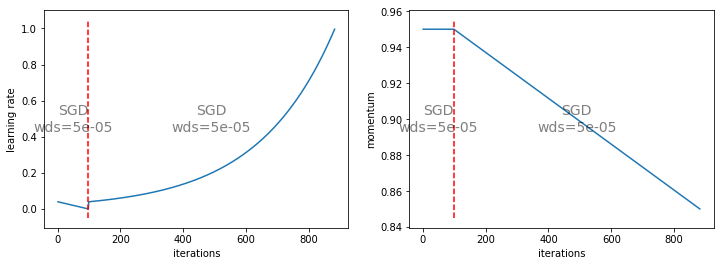

In [42]:
learn.sched.plot_lr()

In [44]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=5e-5
lr=1.2
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.04), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=10, lr=(.04,.9), lr_decay=DecayType.EXPONENTIAL, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

 68%|██████▊   | 67/98 [00:05<00:02, 12.27it/s, loss=1.6] 

Exception in thread Thread-436:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.44591    1.190425   0.5626    
    1      1.207164   1.193157   0.6051                   
    2      0.990962   0.870603   0.7023                    
    3      0.801405   0.972999   0.6834                    
    4      0.692669   0.786937   0.7417                    
    5      0.600746   0.593546   0.7948                    
    6      0.536652   0.649064   0.7884                    
    7      0.514753   0.562664   0.8095                    
    8      0.474542   0.630671   0.8012                    
    9      0.482716   0.724706   0.7753                    
    10     0.514703   1.059147   0.6616                    



[array([1.05915]), 0.6616000004291535]

In [46]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=5e-5
lr=1.2
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .08), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=10, lr=(.08,.9), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.516574   1.523376   0.4545    
    1      1.216384   1.386647   0.5568                   
    2      0.989549   1.046911   0.6554                    
    3      0.802942   0.930375   0.6757                    
    4      0.683606   1.049417   0.6817                    
    5      0.606584   0.695874   0.7714                    
    6      0.553311   0.849601   0.7435                    
    7      0.492958   0.601467   0.8071                    
    8      0.468651   0.947667   0.7236                    
    9      0.461695   0.633913   0.7988                    
    10     0.443599   0.735604   0.7846                    
    11     0.418904   0.692418   0.7818                    



[array([0.69242]), 0.7817999978065491]

In [47]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=5e-5
lr=1.2
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .08), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=10, lr=(.08,.8), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.560654   1.449268   0.4913    
    1      1.205908   1.148933   0.6068                   
    2      1.02553    1.304383   0.5993                   
    3      0.835705   1.025464   0.643                     
    4      0.698056   0.882131   0.7014                    
    5      0.596322   0.771745   0.7491                    
    6      0.537337   0.696305   0.7705                    
    7      0.494024   1.272275   0.6775                    
    8      0.474927   0.677568   0.785                     
    9      0.44198    0.612871   0.8004                    
    10     0.447866   0.982635   0.7595                    
    11     0.418682   0.595285   0.8063                    



[array([0.59529]), 0.806299999332428]

In [51]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=5e-5
lr=1.2
learn.clip = 3e-2
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .08), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=12, lr=(.08,.8), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=12, lr=(.8,.08), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.557638   2.299671   0.3591    
    1      1.212952   1.153321   0.6076                   
    2      0.980975   0.89169    0.6906                    
    3      0.806878   1.259274   0.626                     
    4      0.67743    0.853906   0.7202                    
    5      0.577781   0.602288   0.7997                    
    6      0.530176   0.657255   0.7797                    
    7      0.491681   0.793932   0.7381                    
    8      0.454081   0.660317   0.7803                    
    9      0.429935   0.599835   0.7968                    
    10     0.403083   0.587469   0.8186                    
    11     0.386966   0.497521   0.8387                    
    12     0.385295   0.600526   0.8167                    
    13     0.362977   0.516909   0.8317                    
    14     0.343218   0.533029   0.8243                    
    15     0.319177   0.470309   0.8471                   

[array([0.29515]), 0.9194999994277954]

In [52]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=5e-5
lr=1.2
learn.clip = 3e-2
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .08), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=13, lr=(.08,.7), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=13, lr=(.7,.04), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=4, lr=(.04,.004), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.519103   1.424092   0.5225    
    1      1.150624   1.184188   0.6162                   
    2      0.946004   0.992027   0.6635                    
    3      0.762649   0.779844   0.7419                    
    4      0.636289   0.741833   0.7529                    
    5      0.561814   0.717107   0.7598                    
    6      0.514578   0.593027   0.8026                    
    7      0.479064   0.63399    0.7983                    
    8      0.452762   0.558991   0.8204                    
    9      0.415817   0.618625   0.799                     
    10     0.390795   0.491766   0.8374                    
    11     0.375982   0.58053    0.8117                    
    12     0.365253   0.493909   0.8436                    
    13     0.33955    0.455188   0.8628                    
    14     0.321202   0.453856   0.8528                    
    15     0.3091     0.443087   0.8606                   

[array([0.2889]), 0.9273000017166138]

In [53]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=1.2
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .08), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=13, lr=(.08,.8), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=13, lr=(.8,.04), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=4, lr=(.04,.004), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.592334   2.61505    0.3586    
    1      1.22685    1.158192   0.5936                   
    2      0.980555   1.431943   0.5561                    
    3      0.817612   0.773175   0.7283                    
    4      0.674902   0.813979   0.7189                    
    5      0.599276   0.534584   0.8153                    
    6      0.547498   0.568246   0.8075                    
    7      0.499838   0.707054   0.7696                    
    8      0.481806   0.526269   0.817                     
    9      0.449996   0.56823    0.8215                    
    10     0.425169   0.530011   0.8213                    
    11     0.41142    0.614642   0.8066                    
    12     0.3927     0.587804   0.8254                    
    13     0.38734    0.556392   0.8242                    
    14     0.374561   0.701079   0.7809                    
    15     0.366373   0.649447   0.7988                   

[array([0.2466]), 0.9322999992370605]

In [56]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=2e-4
lr=1.2
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .08), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=13, lr=(.08,.8), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=13, lr=(.8,.04), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=4, lr=(.04,.01), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.557802   1.595108   0.4547    
    1      1.241909   1.107443   0.6018                   
    2      0.976047   0.955262   0.6627                    
    3      0.797054   0.733082   0.7405                    
    4      0.689586   1.110039   0.6382                    
    5      0.624121   0.912516   0.6856                    
    6      0.574387   0.731395   0.7501                    
    7      0.558561   1.033392   0.6729                    
    8      0.523074   1.060453   0.7047                    
    9      0.523337   0.929236   0.6952                    
    10     0.522421   0.664197   0.7778                    
    11     0.504242   0.665434   0.7818                    
    12     0.511172   2.021752   0.5536                    
    13     0.519933   1.089162   0.6502                    
    14     0.508697   0.614903   0.8005                    
    15     0.472782   0.893891   0.702                    

[array([0.21114]), 0.9319000017166138]

In [ ]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=2e-4
lr=1.2
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .08), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=13, lr=(.08,.8), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=13, lr=(.8,.04), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=4, lr=(.04,.01), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

In [57]:
def get_TTA_accuracy(learn):
    preds, targs = learn.TTA()
    # combining the predictions across augmented and non augmented inputs
    preds = 0.6 * preds[0] + 0.4 * preds[1:].sum(0)
    return accuracy_np(preds, targs)

def get_TTA_accuracy_2(learn):
    log_preds,y = learn.TTA()
    preds = np.mean(np.exp(log_preds),0)
    acc = accuracy(torch.FloatTensor(preds),torch.LongTensor(y))
    print('TTA acc:', acc)

In [58]:
get_TTA_accuracy(learn)

AttributeError: 'ModelData' object has no attribute 'aug_dl'

In [60]:
get_TTA_accuracy_2(learn)

AttributeError: 'ModelData' object has no attribute 'aug_dl'

### END TESTING

In [ ]:
m = pre_resnet18()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=6, lr=(.05,.9), lr_decay=DecayType.COSINE, momentum=(0.95,0.85), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=4, lr=1, momentum=0.85),
    TrainingPhase(**def_phase, epochs=7, lr=(.9,.01), lr_decay=DecayType.COSINE, momentum=(0.85,0.95), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=3, lr=(.01,.0005), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

In [ ]:
learn.sched.plot_lr()

In [ ]:
m = WideResNetConcat(num_groups=3, N=3, num_classes=10, k=1, drop_p=0.)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=1.5
learn.clip = 3e-1
%time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(12,22,0.95,0.85), loss_scale=512)